In [55]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler  

# E-jeep Data Set

This dataset contains chronological data with regards to the location of the E-Jeep on Line A.

In [56]:
import csv 
import pandas as pd

# convert to array
with open('../E-Jeep Data/Ejeep Sept 18.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    data = list(csv_reader)
    
# get track data and remove waypoints
for i,row in enumerate(data):
    if(len(row) > 0 and row[0] == 'Track'):
        data = data[i+1:]
        break

# remove header
header = data[0]
data = data[1:]

# convert to float and breakdown time data
for i in range(len(data)):
    data[i][3] = float(data[i][3])
    data[i][4] = float(data[i][4])
    
    # print(data[i]+data[i][1].replace('/', ' ').replace(':', ' ').replace('-', ' ').replace('.', ' ').split())
    
    # hack to get individual time data
    timelog = [int(x) for x in data[i][1].replace('/', ' ').replace(':', ' ').replace('-', ' ').replace('.', ' ').split()]
    data[i] += timelog

header += ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Millisecond']   

# convert to dataframe
df = pd.DataFrame(data, columns=header)

df.head(10)

,Date(GMT),Date(Local),Time(sec),Latitude,Longitude,Horizontal Accuracy(m),Altitude(m),Vertical Accuracy(m),Distance(m),Speed(m/s),...,Heading Accuracy(deg),Glide Ratio,Heart Rate (bpm),Year,Month,Day,Hour,Minute,Second,Millisecond
0,2023-09-18 04:52:44.00,2023-09-18 12:52:44.00,0.0003160238265991211,14.634736,121.076293,3.535533905932737,60.64281845092773,3,0,0,...,11.94986534118652,1018.12073776826,0,2023,9,18,12,52,44,0
1,2023-09-18 04:52:45.00,2023-09-18 12:52:45.00,0.5302410125732422,14.634736,121.076293,4.612905477116144,60.64281840994954,3.541982508706206,0,0,...,11.94986534118652,296.1881525974027,0,2023,9,18,12,52,45,0
2,2023-09-18 04:52:46.00,2023-09-18 12:52:46.00,1.522344946861267,14.634737,121.076293,4.612905477623176,61.00182719901204,3.541982508045873,0.04856229260522659,0,...,11.94986534118652,-171.6421289682452,0,2023,9,18,12,52,46,0
3,2023-09-18 04:52:47.00,2023-09-18 12:52:47.00,2.522934913635254,14.634726,121.076292,4.612905509348495,60.74187846761197,3.541982466728363,1.215731137435719,0,...,11.94986534118652,12.49411691942023,0,2023,9,18,12,52,47,0
4,2023-09-18 04:52:48.00,2023-09-18 12:52:48.00,3.522957921028137,14.634731,121.076293,4.612905492281161,61.36095805745572,3.541982488956028,1.796300261823075,0,...,11.91374492645264,3.42105642573424,0,2023,9,18,12,52,48,0
5,2023-09-18 04:52:49.00,2023-09-18 12:52:49.00,4.522933006286621,14.634732,121.076295,4.612905484480541,61.51488872151822,3.541982499115176,2.005280110045816,0,...,11.91004085540771,1.07442003648176,0,2023,9,18,12,52,49,0
6,2023-09-18 04:52:50.00,2023-09-18 12:52:50.00,5.522817015647888,14.634723,121.076296,4.612905503255921,61.07604594808072,3.541982474663035,2.980479474989021,0,...,11.91004085540771,1.310678106902141,0,2023,9,18,12,52,50,0
7,2023-09-18 04:52:51.00,2023-09-18 12:52:51.00,6.522790908813477,14.634720,121.076298,4.612905504615512,61.28716655354947,3.54198247289237,3.372537853205944,0,...,11.90593814849854,1.197349547133804,0,2023,9,18,12,52,51,0
8,2023-09-18 04:52:52.00,2023-09-18 12:52:52.00,7.522742986679077,14.634720,121.076298,4.612905502314121,61.66930766776204,3.54198247588959,3.457050379974796,0,...,11.90456295013428,1.401959559558112,0,2023,9,18,12,52,52,0
9,2023-09-18 04:52:53.00,2023-09-18 12:52:53.00,8.023118019104004,14.634718,121.076300,4.612905498615977,61.98272319417447,3.541982480705871,3.715026664938944,0,...,11.90456295013428,1.606592499835722,0,2023,9,18,12,52,53,0


## Plot Time Series

We use the "Latitude" and "Longitude" values to filter to data frame `df` and plot the graph using `.plot()`.

<Axes: >

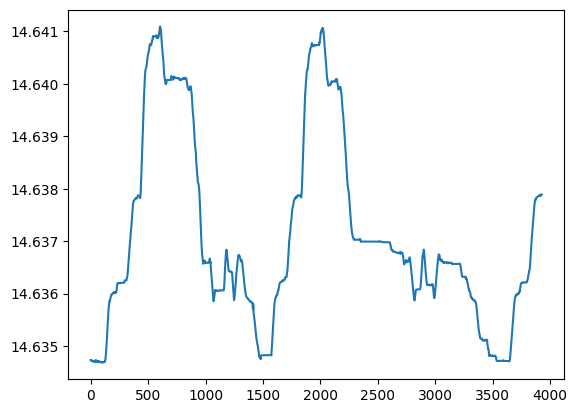

In [57]:
df["Latitude"].plot()

<Axes: >

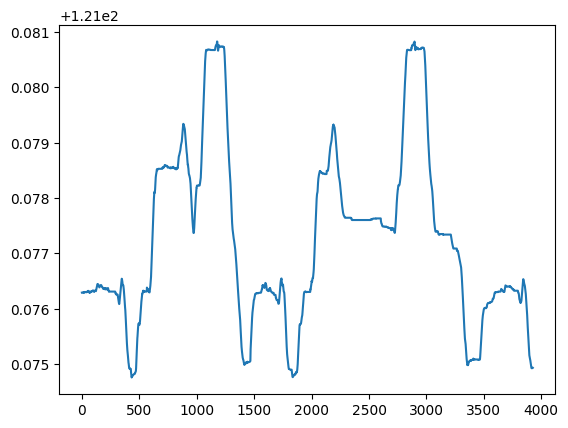

In [58]:
df["Longitude"].plot()

# Extracting `X` and `Y`

To define our `X` dataset and labels `Y`, we first need to define a sequence length (given by variable `sequence_length`) to define the length of a single observation / pattern. For example, if `sequence_length = 5` then a single `x` observation is `5` consecutive measurements. We also define a function `sliding_window()` which accepts the entire chronological data as an array and the `sequence_length` to return two values: An array of `x` observations with length `sequence_length` and an array of `y` corresponding to the next values of each `x` observation. We would also maintain a ratio to represent how much of the `x` observations and `y` labels will belong to the training set and which ones will belong to the test set.

In [59]:
def sliding_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]

        x.append(_x)
        y.append([_y])

    return np.array(x), np.array(y)

In [60]:
# Change this value to change the sequence length. Initially set to 5
sequence_length = 5

# Change this value to change how much training data we would allocate. Initially set to 0.67
ratio = 0.67

## Prepare Training and Testing Data

This splits the data into the following:


* `train_x`: The set of observations
* `train_y`: The predicted value of each observation
* `test_x`: The set of test observations for prediction after training
* `test_y`: The predicted value of each test observation for validation



In [79]:
lat_data = df["Latitude"].values
long_data = df["Longitude"].values

lat_x, lat_y = sliding_window(lat_data, sequence_length)
lat_x, lat_y = sliding_window(lat_data, sequence_length)
long_x, long_y = sliding_window(long_data, sequence_length)
long_x, long_y = sliding_window(long_data, sequence_length)

train_size = int(len(lat_y) * ratio)
test_size = len(lat_y) - train_size

# Turn them into tensors for computation later on
lat_data_x = Variable(torch.Tensor(np.array(lat_x)))
lat_data_y = Variable(torch.Tensor(np.array(lat_y)))
long_data_x = Variable(torch.Tensor(np.array(long_x)))
long_data_y = Variable(torch.Tensor(np.array(long_y)))

lat_train_x = Variable(torch.Tensor(np.array(lat_x[0:train_size])))
lat_train_y = Variable(torch.Tensor(np.array(lat_y[0:train_size])))
long_train_x = Variable(torch.Tensor(np.array(long_x[0:train_size])))
long_train_y = Variable(torch.Tensor(np.array(long_y[0:train_size])))

lat_test_x = Variable(torch.Tensor(np.array(lat_x[train_size:len(lat_x)])))
lat_test_y = Variable(torch.Tensor(np.array(lat_y[train_size:len(lat_y)])))
long_test_x = Variable(torch.Tensor(np.array(long_x[train_size:len(long_x)])))
long_test_y = Variable(torch.Tensor(np.array(long_y[train_size:len(long_y)])))

# Feature Engineering

Since MLP is sensitive to feature scaling, it will be carried out as such using MinMaxScaler.

In [62]:
""" scaler = MinMaxScaler(feature_range=(-1,1))

scaler.fit(lat_train_x)
scaler.fit(long_train_x)

lat_train_x = Variable(torch.Tensor(scaler.transform(lat_train_x)))
long_train_x = Variable(torch.Tensor(scaler.transform(long_train_x)))

lat_test_x = Variable(torch.Tensor(scaler.transform(lat_test_x)))
long_test_x = Variable(torch.Tensor(scaler.transform(long_test_x))) """

' scaler = MinMaxScaler(feature_range=(-1,1))\n\nscaler.fit(lat_train_x)\nscaler.fit(long_train_x)\n\nlat_train_x = Variable(torch.Tensor(scaler.transform(lat_train_x)))\nlong_train_x = Variable(torch.Tensor(scaler.transform(long_train_x)))\n\nlat_test_x = Variable(torch.Tensor(scaler.transform(lat_test_x)))\nlong_test_x = Variable(torch.Tensor(scaler.transform(long_test_x))) '

# Multilayer Perceptron

This algorithm is an example of a fully connected neural network implemented in Pytorch. It is a rather simple implementation with only a set of neurons for the input layer, another set of neurons for the hidden layer and another set for the output layer. To configure the network, define the following parameters:
* `input_size`: The dimensionality of the input layer
* `hidden_size`: The dimensionality of the hidden layer
* `output_size`: The dimensionality of `y` in the output layer

To change the activation functions of the model, you can refer to this documentation:

https://pytorch.org/docs/stable/nn.functional.html

For more information about how `nn.Linear` works, check the following documentation:

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [80]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # f(x) = a(f(x))
        x = F.relu(self.hidden(x))
        y = F.relu(self.output(x))

        return y

# Model Configuration

Change these values before instantiating the multilayer perceptron model.

In [81]:
# Since each observation's dimensionality is defined by seequence_length, let's use that value
input_size = sequence_length

# Hidden size
hidden_size = 25

# Output size (number of classes)
output_size = 1

# Instantiate the model
model = MultiLayerPerceptron(input_size, hidden_size, output_size)

# Training

To train an instance of the `MultilayerPerceptron`, we'll first have to define some training parameters:
* `epochs`: How many times it would iterate against the dataset to optimize `W`
* `learning_rate`: How aggressive we want to look for a local minimum value.
* `criterion`: The loss function for training
* `optimizer`: Our problem solver to minimize `W`

In [82]:
# Change this to shorted or lengthen training time
epochs = 100

# Change this to modify the learning rate of the optimizer
learning_rate = 0.001

# Change this to a loss function implementation. Initially we'll use MSE
criterion = torch.nn.MSELoss()

# Change this to define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### The Actual Training Process

In [102]:
for epoch in range(epochs):
    lat_outputs = model.forward(lat_train_x)
    long_outputs = model.forward(long_train_x)

    optimizer.zero_grad()

    # obtain the loss function
    lat_loss = criterion(lat_outputs, lat_train_y)
    long_loss = criterion(long_outputs, long_train_y)

    lat_loss.backward()
    long_loss.backward()

    optimizer.step()

    print("Epoch: %d, Latitude loss: %1.5f, Longitude loss: %1.5f" % (epoch, lat_loss.item(), long_loss.item()))

Epoch: 0, Latitude loss: 0.48075, Longitude loss: 28.41507
Epoch: 1, Latitude loss: 0.41188, Longitude loss: 24.07005
Epoch: 2, Latitude loss: 0.35112, Longitude loss: 20.26002
Epoch: 3, Latitude loss: 0.29775, Longitude loss: 16.93559
Epoch: 4, Latitude loss: 0.25107, Longitude loss: 14.05012
Epoch: 5, Latitude loss: 0.21044, Longitude loss: 11.55989
Epoch: 6, Latitude loss: 0.17523, Longitude loss: 9.42398
Epoch: 7, Latitude loss: 0.14490, Longitude loss: 7.60420
Epoch: 8, Latitude loss: 0.11891, Longitude loss: 6.06517
Epoch: 9, Latitude loss: 0.09676, Longitude loss: 4.77416
Epoch: 10, Latitude loss: 0.07803, Longitude loss: 3.70113
Epoch: 11, Latitude loss: 0.06228, Longitude loss: 2.81852
Epoch: 12, Latitude loss: 0.04914, Longitude loss: 2.10116
Epoch: 13, Latitude loss: 0.03828, Longitude loss: 1.52632
Epoch: 14, Latitude loss: 0.02939, Longitude loss: 1.07342
Epoch: 15, Latitude loss: 0.02218, Longitude loss: 0.72400
Epoch: 16, Latitude loss: 0.01641, Longitude loss: 0.46158
E

# Predictions

We then call `model.eval()` to freeze `W` and attempt to predict `test_y`.

In [103]:
model.eval()
lat_predictions = model(lat_test_x).detach().numpy()
long_predictions = model(long_test_x).detach().numpy()

lat_predictions = lat_predictions.ravel()
long_predictions = long_predictions.ravel()

lat_predictions
long_predictions

array([121.050476, 121.050476, 121.050476, ..., 121.04793 , 121.04793 ,
       121.04794 ], dtype=float32)

## Observe the Predicted Values

Let's plot both `test_y` and `predictions` to see how far they are from each other.

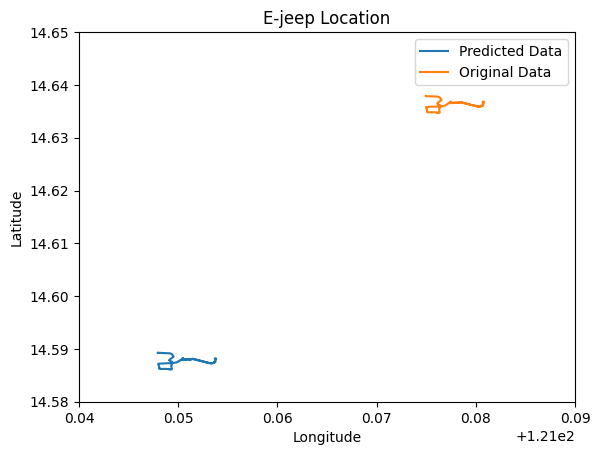

In [109]:
plt.title("E-jeep Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.plot(long_predictions, lat_predictions, label="Predicted Data")
plt.plot(long_test_y, lat_test_y, label="Original Data")
plt.xlim(121.04, 121.09)
plt.ylim(14.58, 14.65)
plt.legend()
plt.show()

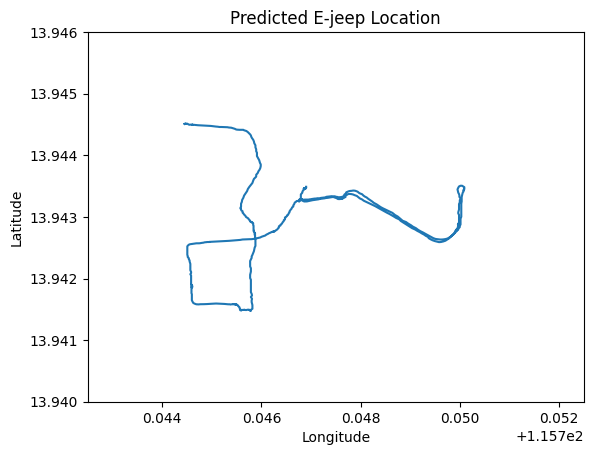

In [101]:
plt.title("Predicted E-jeep Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.plot(long_predictions, lat_predictions)
plt.xlim(115.7425, 115.7525)
plt.ylim(13.94, 13.946)
plt.show()

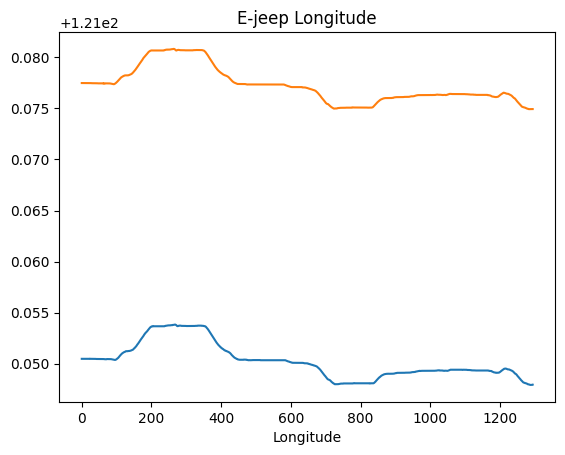

In [110]:
x_axis_values = np.arange(0,len(long_predictions))

plt.title("E-jeep Longitude")
plt.xlabel("Longitude")
plt.plot(x_axis_values, long_predictions, label="Predicted Data")
plt.plot(x_axis_values, long_test_y, label="Original Data")
plt.show()

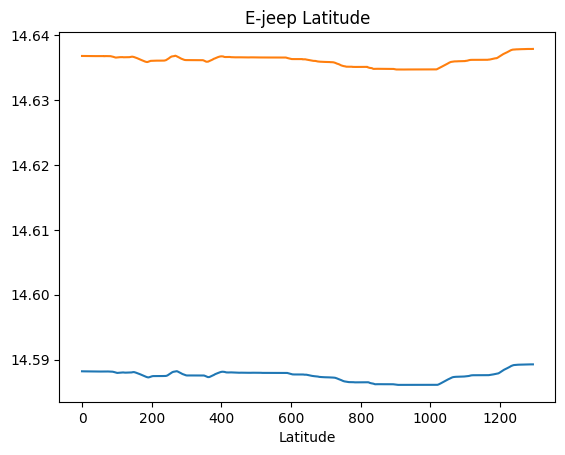

In [111]:
x_axis_values = np.arange(0,len(lat_predictions))

plt.title("E-jeep Latitude")
plt.xlabel("Latitude")
plt.plot(x_axis_values, lat_predictions, label="Predicted Data")
plt.plot(x_axis_values, lat_test_y, label="Original Data")
plt.show()

# Evaluation Metric

The following Evaluation Metrics will be used:
* Root Mean Squared Error (RMSE)
* Adjusted R^2 Score
* Mean Absolute Error (MAE)

In [112]:
from sklearn.metrics import mean_squared_error

long_rmse = mean_squared_error(long_test_y, long_predictions, squared=False)
lat_rmse = mean_squared_error(lat_test_y, lat_predictions, squared=False)

long_rmse
lat_rmse

0.048617236

In [113]:
from sklearn.metrics import r2_score
  
long_r2 = 1-(1-r2_score(long_test_y, long_predictions))*((len(long_test_x)-1)/(len(long_test_x)-len(long_test_x[0])-1))
lat_r2 = 1-(1-r2_score(lat_test_y, lat_predictions))*((len(lat_test_x)-1)/(len(lat_test_x)-len(lat_test_x[0])-1))

long_r2
lat_r2

-3693.3492846633035

In [114]:
from sklearn.metrics import r2_score

def r2_adj(x,y):
    r2 = r2_score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    return 1-(1-r2)*(n-1)/(n-p-1)

long_r2 = r2_adj(long_test_y, long_predictions)

long_r2

-245.65810779397668